In [1]:
from fastai.vision.all import *

In [30]:
paintings = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    get_items=get_image_files,
                    splitter=RandomSplitter(valid_pct=0.2, seed=42),
                    get_y=parent_label,
                    item_tfms=RandomResizedCrop(244, min_scale=0.3),
                    batch_tfms=aug_transforms())

In [31]:
dls= paintings.dataloaders('resources/cleaned', num_workers=0 )

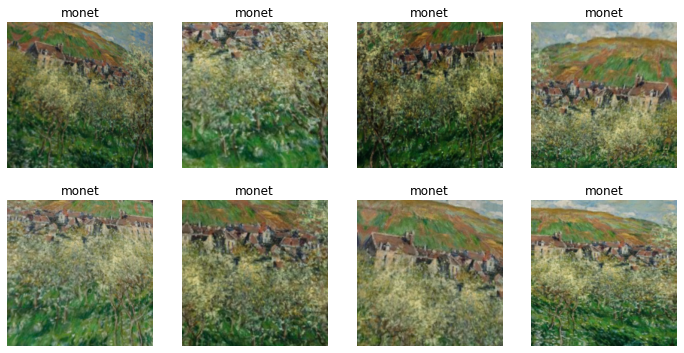

In [32]:
dls.train.show_batch(max_n=8,nrows=2,unique=True)

In [33]:
learn_34 = cnn_learner(dls, resnet34, metrics=accuracy)

In [34]:
learn_34.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,2.357110,1.113864,0.648438,00:10


epoch,train_loss,valid_loss,accuracy,time
0,1.319126,0.837456,0.734375,00:11
1,1.182493,0.710286,0.773438,00:10
2,1.010527,0.614226,0.785156,00:10
3,0.866495,0.699728,0.757812,00:10
4,0.734050,0.673396,0.808594,00:10
5,0.611169,0.640705,0.824219,00:10
6,0.512538,0.665023,0.824219,00:10
7,0.434479,0.685180,0.824219,00:10
8,0.374672,0.689668,0.824219,00:10
9,0.331355,0.691247,0.820312,00:10


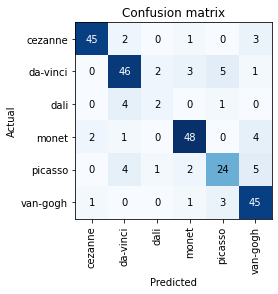

In [35]:
interp = ClassificationInterpretation.from_learner(learn_34)
interp.plot_confusion_matrix()

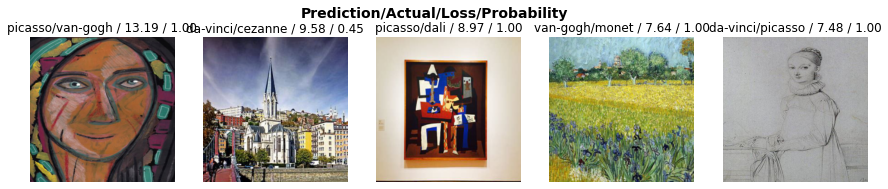

In [36]:
interp.plot_top_losses(5, nrows=1)

In [28]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn_34)
cleaner

In [29]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [37]:
learn_34.export(fname='firstmodel.pkl')